In [56]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("ilsilfverskiold/tech-keywords-extractor")
model = AutoModelForSeq2SeqLM.from_pretrained("ilsilfverskiold/tech-keywords-extractor")

This model finds the most important keywords in a sentence. This is used to filter the claims text to an accaptable length and then calculate the entropy.

In [57]:
sequence = "I have a problem with my code. I am trying to run a python script that uses the pandas library. However, I keep getting an error message that says 'no module named pandas'. I have tried reinstalling the library, but that did not fix the issue. Can someone help me troubleshoot this problem?"

tokens = tokenizer(sequence, padding=True, truncation=True, return_tensors="pt")

summary = model.generate(**tokens)

In [58]:
tokenizer.decode(summary[0], skip_special_tokens=True)

'Python, Pandas, Error Message'

In [59]:
import pandas as pd
import math as mt
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import nltk
import operator
import re

from helpers import *

In [60]:
def update_total_counts(counts_total: dict, tokens: list) -> dict:
    for token, count in tokens.items():
        if token in counts_total:
            counts_total[token] += count
        else:
            counts_total[token] = count
    return counts_total

def get_entropy(counts: dict) -> float:
    """
    Calculate the entropy of a dictionary of token counts
    """
    entropy = 0
    total = sum(counts.values())
    for token, count in counts.items():
        if count > 0:
            p = count / total
            entropy = p * mt.log2(1/p)
    return entropy

In [61]:
names = ["FW", "LC", "LIB",  "SC", "SPV", "Wind"]  # technology file names
n = "Wind"  # other tech

In [62]:
df = pd.read_excel(f'sorted_data/DB_{n}_USPTO_sorted.xlsx')
df['Publn_Nr'] = df['Publn_Nr'].astype(int)

In [63]:
patent_claims = []  # list to store all patents claims for technology for year
list_replace = []
stwrds = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [64]:
def get_tokens(text: str) -> tuple[list, dict]:
    # Standardize greek letters and eliminate symbols
    line = text.strip().lower()
    # Standardize greek letters and eliminate symbols
    for r in list_replace:
        line = line.replace(*r)
    # Replace .sub. and .sup. in each patent
    line = line.replace('.sub.', '')
    line = line.replace('.sup.', '')

    # Tokenize the text
    tokens_encoded = tokenizer(line, padding=True, truncation=True, return_tensors="pt")

    summary = model.generate(**tokens_encoded)

    tokens_decoded = tokenizer.decode(summary[0], skip_special_tokens=True)

    # convert to list
    tokens = tokens_decoded.lower().replace(',', '').split()

    # count
    count = {}
    for token in tokens:
        count[token] = text.count(token)

    return tokens, count

In [ ]:
# get claims ordered by publication date
entropies = []   # conditional entropies for each patent, sorted by publication date
counts_total = {}

counts_dict = {}


for pub_nr in df['Publn_Nr'].unique():
    claims = get_claims(df, pub_nr)
    if claims.empty:
        entropies.append(np.nan)  # add NA if no claims in data set
        continue    # skip if no claims in data set
    text = concantenate_claims(claims)  # concantenate claims
    tokens, count = get_tokens(text)    # get tokens and counts of words
    counts_total = update_total_counts(counts_total, count)   # update total counts for conditional entropy

    # get conditional entropy fixme: get negatives because probability distribution not defined nicely
    """
    H(X|Y) = H(X,Y) - H(Y)
    does not work as H(X,Y) may be smaller then H(Y) in the way that we define probabilities (relative frequency of words).
    approximation: H(X|Y) = H(X)
    """
    cond_entropy = get_entropy(counts_total) # - get_entropy(count)
    entropies.append(cond_entropy)

    # get entropy of compared to the last 20 patents
    """
    H_Y(X) where Y is the last 20 patents, X is the new patent
    it shows a very fluctuating plot, as expected, as the innovation is always "normalized" compared to the last 20 patents
    """
    # counts_dict[pub_nr] = count
    # if len(counts_dict) > 20:
    #     last_20 = dict(list(counts_dict.items())[-20:])
    #     cond_entropy = get_cross_entropy(count, last_20)
    #     entropies.append(cond_entropy)
    # else:
    #     entropies.append(np.nan)
    
    
    # get single entropy
    """
    similar to H_Y(X) 
    """
    # cond_entropy = get_entropy(count)

In [66]:
df_unique = df.drop_duplicates(subset=['Publn_Nr'])[['Publn_Nr', 'Publn_Date']]
df_unique['Entropy'] = entropies

In [78]:
df_unique.loc[int(df_unique['Entropy'].idxmax())]

Publn_Nr         4149092
Publn_Date    1979-04-10
Entropy         0.383376
Name: 661, dtype: object

In [79]:
df_unique[df_unique['Entropy'] > .3]

,Publn_Nr,Publn_Date,Entropy
1,3942026,1976-03-02,0.320160
661,4149092,1979-04-10,0.383376


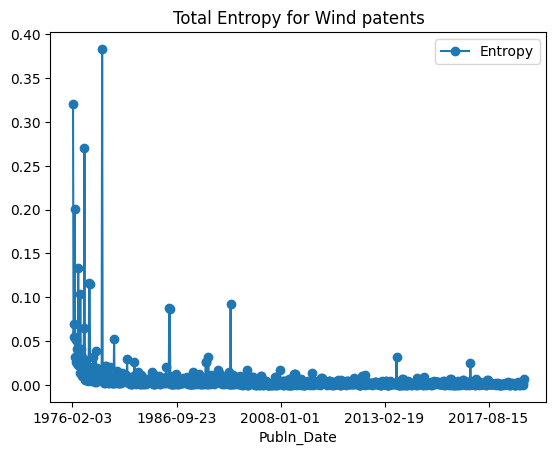

In [67]:
df_unique.plot(x='Publn_Date', y='Entropy', kind='line', marker='o', title=f'Total Entropy for {n} patents')
plt.show()

In [68]:
df_unique.to_csv(f'entropy_data/ML_data/entropy_{n}.csv', index=False)